In [2]:
import os
import yaml
import torch
from clean.data import DeepCleanInferenceDataset
from clean.infer import OnlineInference
from clean.model import InferenceModel

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
os.getcwd()

'/home/chiajui.chou/deepcleanv2/projects/clean'

In [4]:
# Loading configuration from YAML
clean_config_file = "/home/chiajui.chou/deepcleanv2/projects/clean/config_clean.yaml"
with open(clean_config_file, 'r') as file:
    clean_config = yaml.safe_load(file)
print(clean_config.keys())

train_config_file = os.path.join(clean_config['train_dir'], "config.yaml")
with open(train_config_file, 'r') as file:
    train_config = yaml.safe_load(file)
# print(train_config.keys())
print(train_config['data'].keys())
print(train_config['data']['inference_sampling_rate'])

# train_hparams_file = os.path.join(clean_config['train_dir'], "hparams.yaml")
# with open(train_hparams_file, 'r') as file:
#     train_hparams = yaml.safe_load(file)
# print(train_hparams.keys())

# Initialize InferenceModel
model = InferenceModel(
    clean_config['train_dir'],
    clean_config['sample_rate'],
    clean_config['device'],
)

# Initialize DeepCleanInferenceDataset
inference_dataset = DeepCleanInferenceDataset(
    hoft_dir=clean_config['hoft_dir'],
    witness_dir=clean_config['witness_dir'],
    model=model,
    device=clean_config['device'],
)

# Initialize OnlineInference
online_inference = OnlineInference(
    dataset=inference_dataset,
    model=model,
    outdir=clean_config['outdir'],
    device=clean_config['device']
)


dict_keys(['device', 'sample_rate', 'hoft_dir', 'witness_dir', 'outdir', 'train_dir'])
dict_keys(['fname', 'channels', 'kernel_length', 'freq_low', 'freq_high', 'batch_size', 'train_duration', 'test_duration', 'valid_frac', 'train_stride', 'inference_sampling_rate', 'start_offset', 'filt_order'])
2.0


In [5]:
# Run the online inference process for a number of iterations (e.g., 100)
# for k in range(300):
#     online_inference.predict_and_write()
#     online_inference.dataset.update()
#     print(f"iteration {k}")

### InferenceDataset

In [6]:
# Initialize DeepCleanInferenceDataset
inference_dataset = DeepCleanInferenceDataset(
    hoft_dir=clean_config['hoft_dir'],
    witness_dir=clean_config['witness_dir'],
    model=model,
    device=clean_config['device'],
)

print(inference_dataset.t0)
print(inference_dataset.sample_rate)
print(inference_dataset.kernel_size)
print("X_inference:")
print(len(inference_dataset.X_inference))
print(inference_dataset.X_inference.kernel_size)
print(inference_dataset.X_inference.stride)
print("y_inference:")
print(len(inference_dataset.y_inference))
print(inference_dataset.y_inference.kernel_size)
print(inference_dataset.y_inference.stride)

# print(inference_dataset.X_inference.X.shape)
# print(inference_dataset.y_inference.X.shape)
for i, j in zip(inference_dataset.X_inference, inference_dataset.y_inference):
    print(i.shape, j.shape)
    # print(i, j)

1250920943
4096
4096
X_inference:
1
4096
2048
y_inference:
1
4096
4096
torch.Size([5, 21, 4096]) torch.Size([3, 4096])


In [7]:
print(inference_dataset.t0)
X_dset = inference_dataset.X_inference
y_dset = inference_dataset.y_inference
for X, y in zip(X_dset, y_dset):
    print(X.shape)
    print(X[0,0,:])
    print(y.shape)
    print(y[0,:])

# inference_dataset.update()
# print(inference_dataset.t0)

1250920943
torch.Size([5, 21, 4096])
tensor([-0.0271,  0.4559,  0.4565,  ..., -0.3208, -0.3217, -0.3225],
       device='cuda:0')
torch.Size([3, 4096])
tensor([ 2.9104e-19,  3.7755e-19,  3.8445e-19,  ..., -7.9801e-20,
        -7.4546e-20, -7.7965e-20], device='cuda:0')


### Model

In [9]:
device = clean_config['device']
# print(clean_config)
train_dir = clean_config['train_dir']
print(train_dir)
# t_model = torch.jit.load(os.path.join(train_dir, "model.pt")).to(device)
t_model = model.model
print(type(t_model))

/home/chiajui.chou/deepclean/results/train-O3-H1-kernel_1_1_st_0p5_epad_0p2_fpad_0p8_lr_0p2_oclr/lightning_logs/version_0
<class 'torch.jit._script.RecursiveScriptModule'>


### Predictions

batch: 0


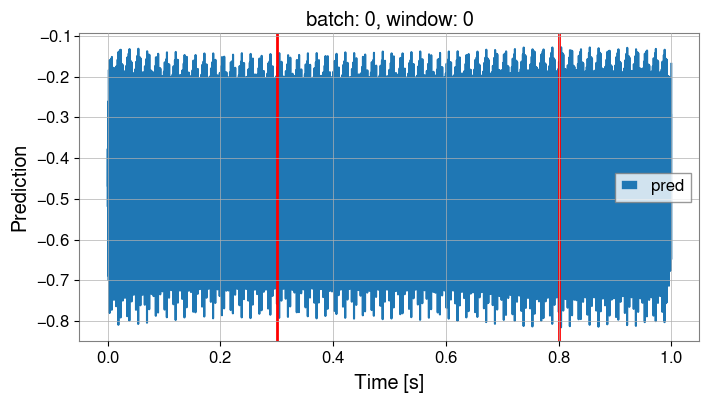

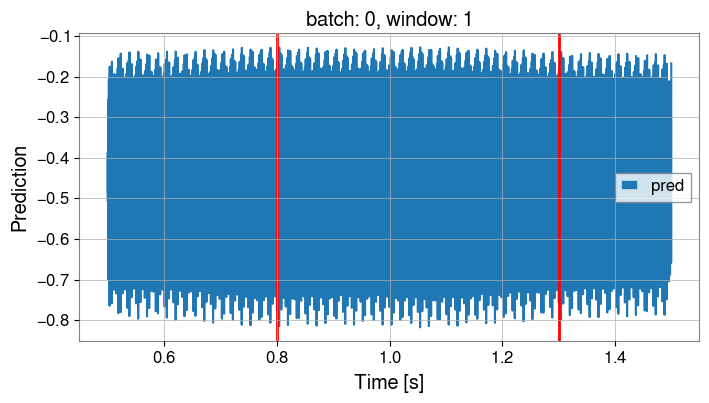

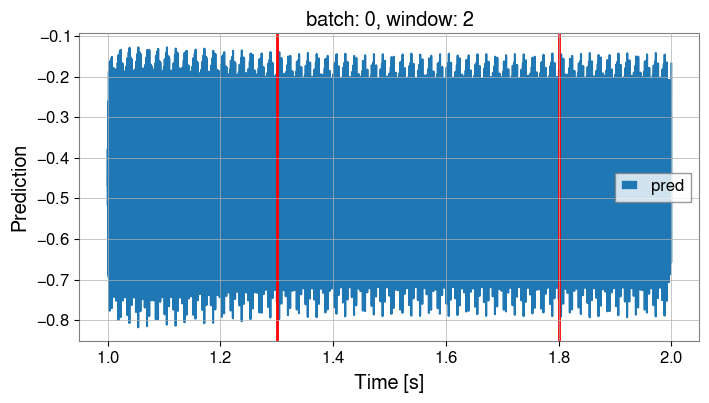

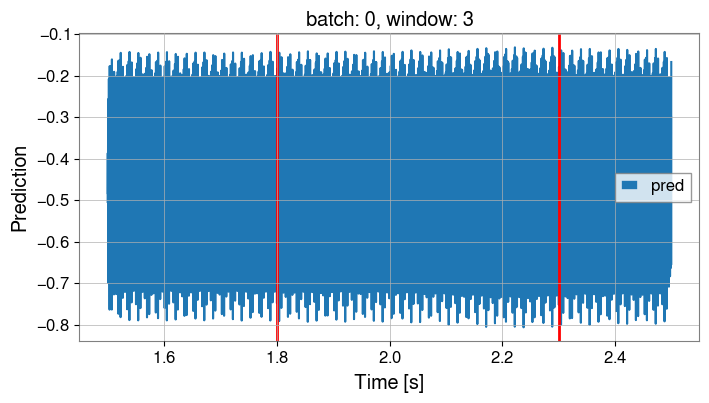

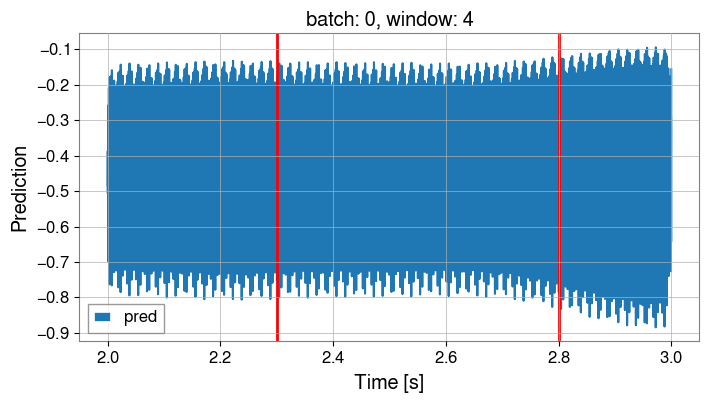

In [10]:
sample_rate = inference_dataset.sample_rate
stride = inference_dataset.stride
kernel_size = inference_dataset.kernel_size
edge_pad = int(0.2 * sample_rate)
strain = (y for y in iter(y_dset))
pred = (t_model(X) for X in iter(X_dset))
w_st = 0
for i, y in enumerate(zip(strain, pred)):
    print(f"batch: {i}")
    strain = y[0]
    p = y[1]
    for j in range(int(p.shape[0])):
        times = np.arange(w_st, w_st + 1, 1/sample_rate)
        st = w_st + (kernel_size - stride - edge_pad)/sample_rate
        ed = st + stride/sample_rate
        w_st += stride/sample_rate
        plt.figure(figsize=[8,4])
        plt.title(f"batch: {i}, window: {j}")
        # plt.plot(times, strain[j].to('cpu').numpy(), label="strain")
        plt.plot(times, p[j].to('cpu').detach().numpy(), label="pred")
        plt.xlabel('Time [s]')
        plt.ylabel('Prediction')
        plt.axvline(st, c='red', lw=2)
        plt.axvline([ed], c='red', lw=2)
        plt.legend()
        plt.show()

### Aggregation

edge_pad: 819, filter_pad: 3276
size: 12288, kernel_size: 4096, stride: 2048, batch_size = 5
11469
offset: 1229


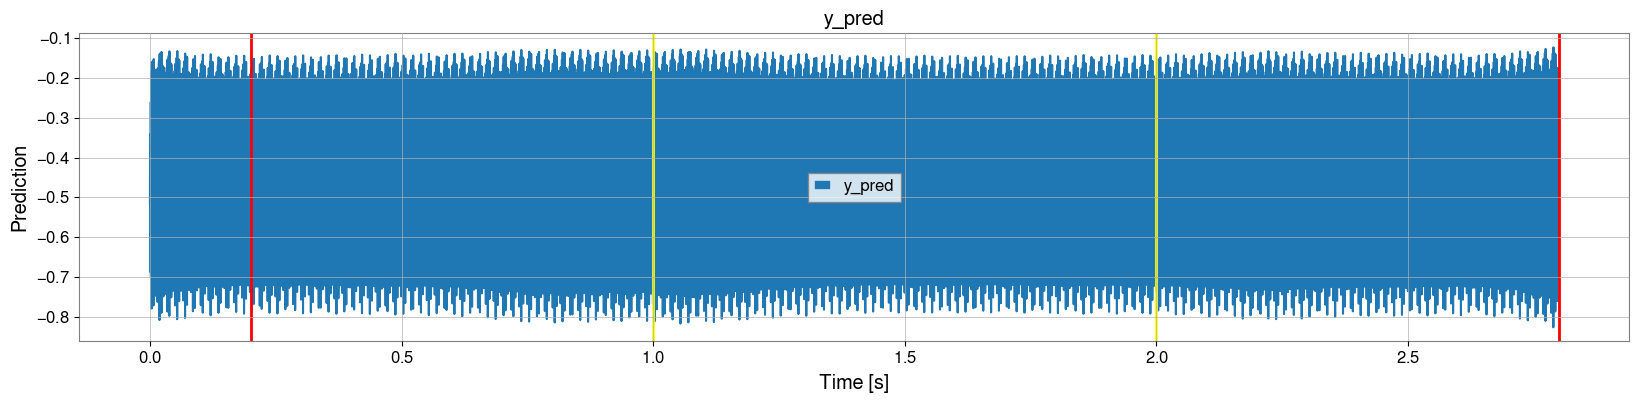

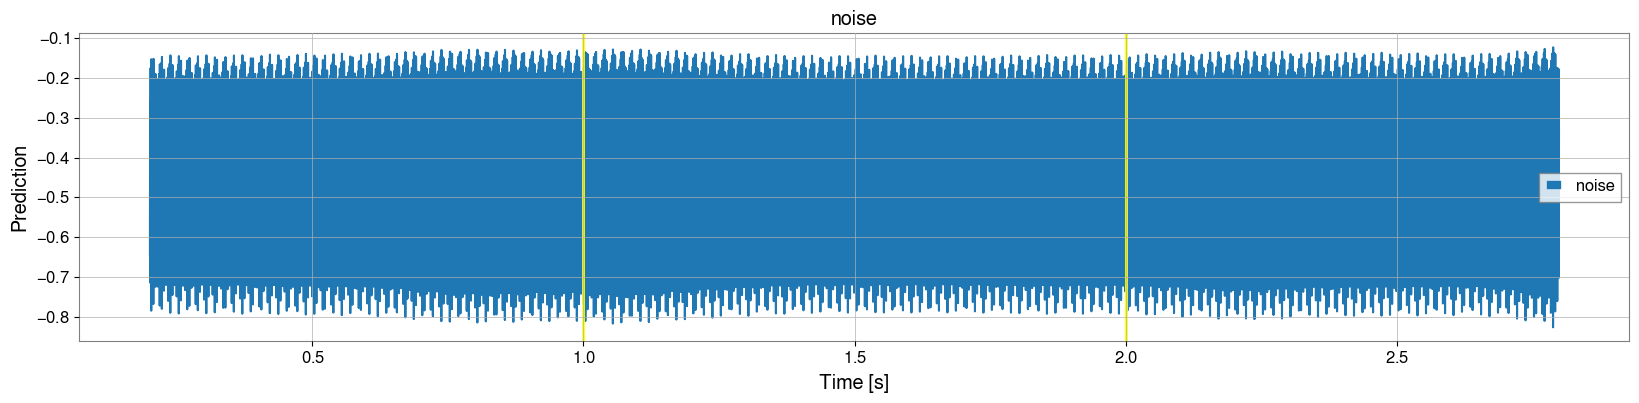

In [21]:
sample_rate = clean_config['sample_rate']
pad_params = train_config['model']['metric']['init_args']
edge_pad = int(pad_params.get('edge_pad') * sample_rate)
filter_pad = int(pad_params.get('filter_pad') * sample_rate)
print(f"edge_pad: {edge_pad}, filter_pad: {filter_pad}")

device = inference_dataset.hparams.device
dtype = inference_dataset.y_inference.X.dtype
size = len(inference_dataset.y_inference.X)
kernel_size = inference_dataset.kernel_size
stride = inference_dataset.X_inference.stride
batch_size = len(next(iter(inference_dataset.X_inference)))
print(f"size: {size}, kernel_size: {kernel_size}, stride: {stride}, batch_size = {batch_size}")

pred = (t_model(X) for X in iter(inference_dataset.X_inference))
y_pred = torch.zeros(
    (size - edge_pad),
    device=device,
    dtype=dtype,
)
print(len(y_pred))
get_idx = torch.arange(
    stride,
    device=device,
)
offset = int(sample_rate - edge_pad - stride)
print(f"offset: {offset}")
get_idx += offset
# print(get_idx.shape)

set_idx = get_idx.view(1, -1).repeat(batch_size, 1)
# print(set_idx)
batch_offset = torch.arange(batch_size, device=device)
set_idx += batch_offset[:, None] * stride
# print(set_idx)

for i, y in enumerate(pred):
    if not i:
        y_pred[:offset] = y[0, :offset]
    sidx = set_idx[:len(y)]
    y_pred[sidx + i*batch_size*stride] = y[:, get_idx]

start = sample_rate - filter_pad
end = 2*sample_rate + filter_pad
# print(start, end)

plt.figure(figsize=[20, 4])
y_pred_times = np.arange(0, y_pred.shape[0]/sample_rate, 1/sample_rate)
plt.title('y_pred')
plt.plot(y_pred_times, y_pred.cpu().detach().numpy(), label='y_pred')
plt.xlabel('Time [s]')
plt.ylabel('Prediction')
plt.axvline(y_pred_times[start], c='red', lw=2)
plt.axvline(y_pred_times[end], c='red', lw=2)
plt.axvline(y_pred_times[start + filter_pad], c='yellow', lw=2)
plt.axvline(y_pred_times[end - filter_pad], c='yellow', lw=2)
plt.legend()
plt.show()

times = y_pred_times[start:end]
noise = y_pred[start:end]
plt.figure(figsize=[20, 4])
plt.title('noise')
plt.plot(times, noise.cpu().detach().numpy(), label='noise')
plt.xlabel('Time [s]')
plt.ylabel('Prediction')
plt.axvline(y_pred_times[start + filter_pad], c='yellow', lw=2)
plt.axvline(y_pred_times[end - filter_pad], c='yellow', lw=2)
plt.legend()
plt.show()

### Postprocess

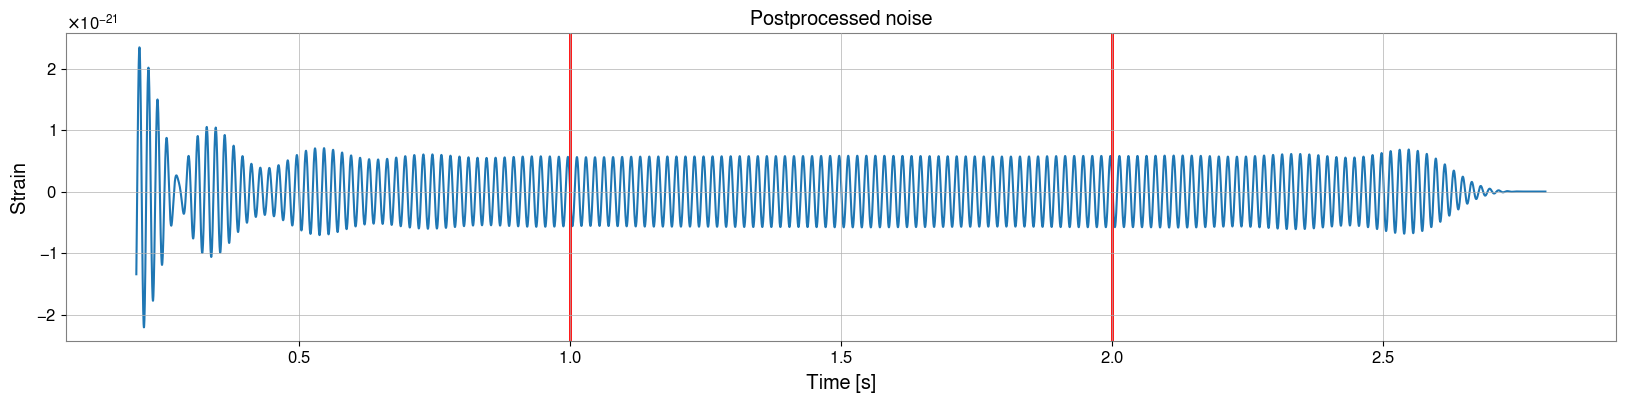

In [22]:
noise = model.y_scaler(noise.double().cpu(), reverse=True)
noise = model.bandpass(noise.detach().numpy())
noise = torch.tensor(noise, device=device).flatten()
plt.figure(figsize=[20, 4])
plt.title('Postprocessed noise')
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.plot(times, noise.cpu().detach().numpy())
plt.axvline(times[filter_pad], c='red', lw=2)
plt.axvline(times[filter_pad+sample_rate], c='red', lw=2)
plt.show()

In [23]:
times = times[filter_pad:-filter_pad]
noise = noise[filter_pad:-filter_pad].double()

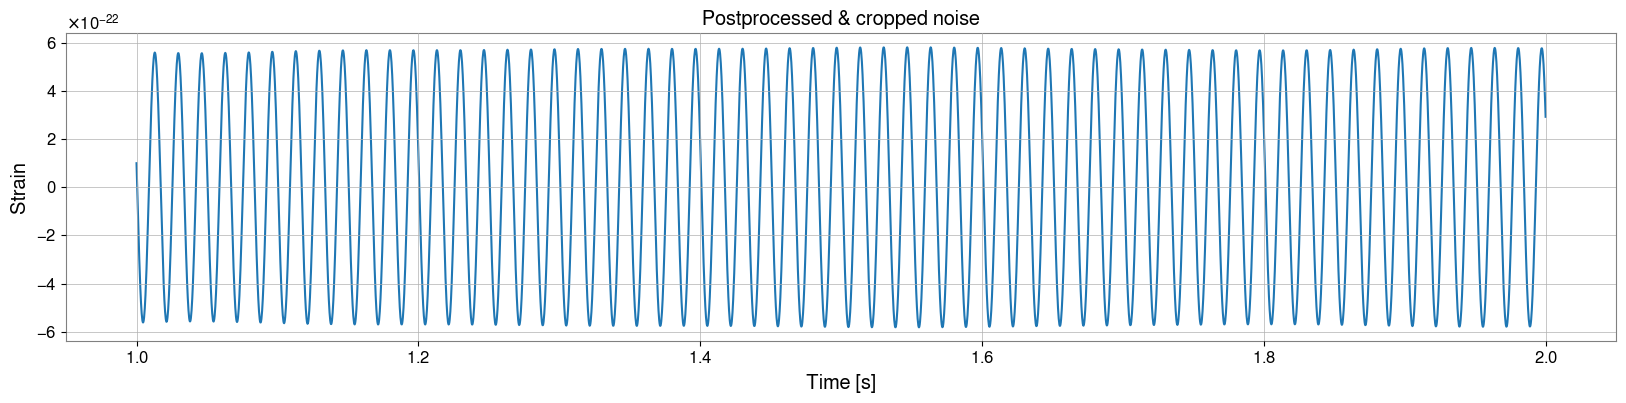

In [24]:
plt.figure(figsize=[20, 4])
plt.title('Postprocessed & cropped noise')
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.plot(times, noise.cpu().detach().numpy())
plt.show()

### Load Raw Strain

In [25]:
inference_dataset.y_inference.X.shape

torch.Size([12288])

Time labels from init buffer: [0.00000000e+00 2.44140625e-04 4.88281250e-04 ... 2.99926758e+00
 2.99951172e+00 2.99975586e+00], 12288
Time labels from the cropped y_pred: [1.         1.00024414 1.00048828 ... 1.99926758 1.99951172
 1.99975586], 4096
Time labels from predicted noise: [1.         1.00024414 1.00048828 ... 1.99926758 1.99951172
 1.99975586], 4096


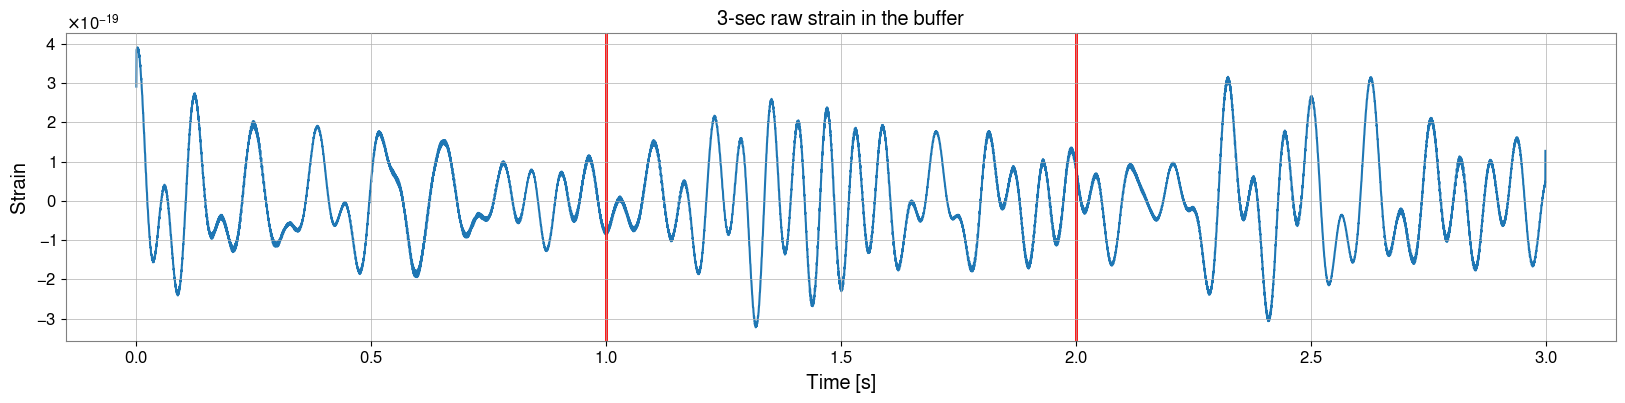

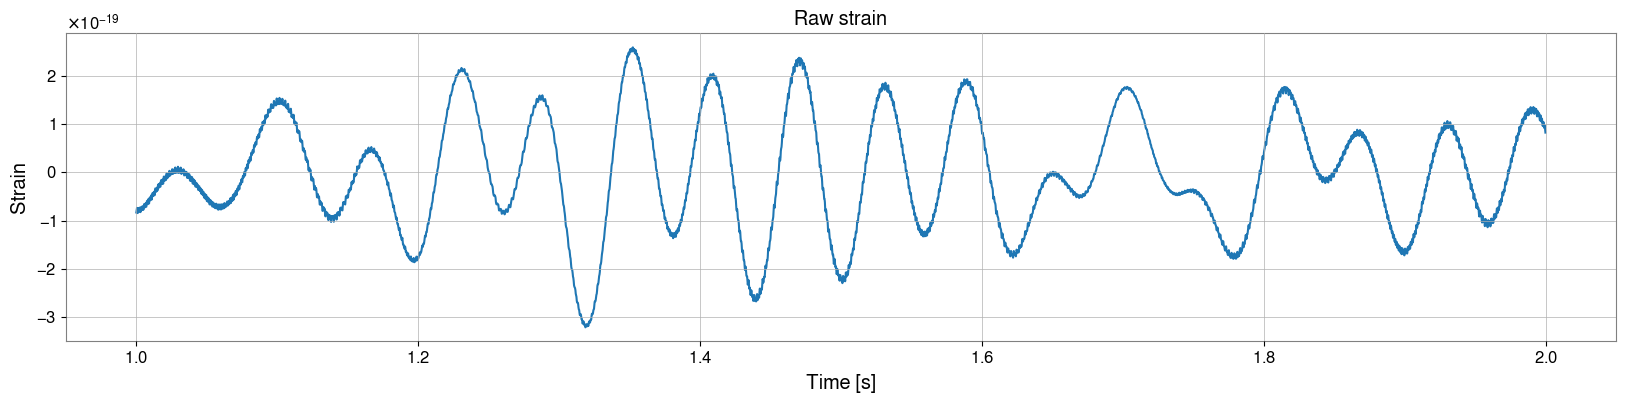

In [26]:
# print(inference_dataset.y_inference.X.shape)
init_times = np.arange(0, len(inference_dataset.y_inference.X)/sample_rate, 1/sample_rate)
print(f"Time labels from init buffer: {init_times}, {len(init_times)}")
print(f"Time labels from the cropped y_pred: {y_pred_times[start+filter_pad:end-filter_pad]}, {len(y_pred_times[start+filter_pad:end-filter_pad])}")
print(f"Time labels from predicted noise: {times}, {len(times)}")
raw_start = start + filter_pad
raw_end = end - filter_pad
raw = inference_dataset.y_inference.X[raw_start:raw_end].double()
# print(raw.shape)

buffer = inference_dataset.y_inference.X
buffer_times = np.arange(0, len(buffer)/sample_rate, 1/sample_rate)
plt.figure(figsize=[20, 4])
plt.title('3-sec raw strain in the buffer')
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.plot(buffer_times, buffer.cpu().numpy())
plt.axvline(buffer_times[raw_start], c='red', lw=2)
plt.axvline(buffer_times[raw_end], c='red', lw=2)
plt.show()

plt.figure(figsize=[20, 4])
plt.title('Raw strain')
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.plot(times, raw.cpu().numpy())
plt.show()

### Clean

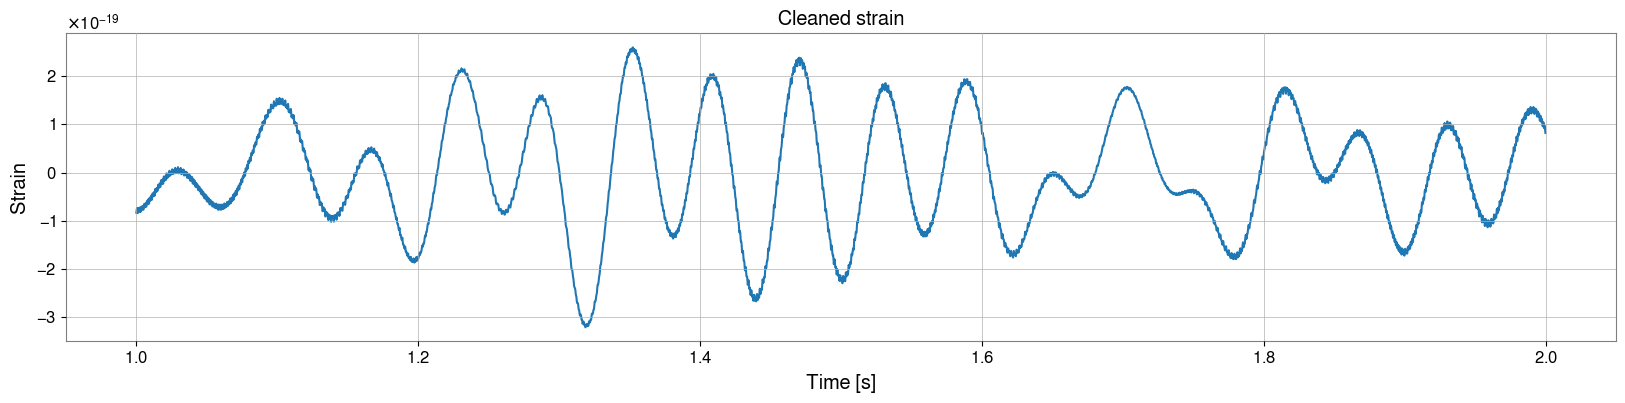

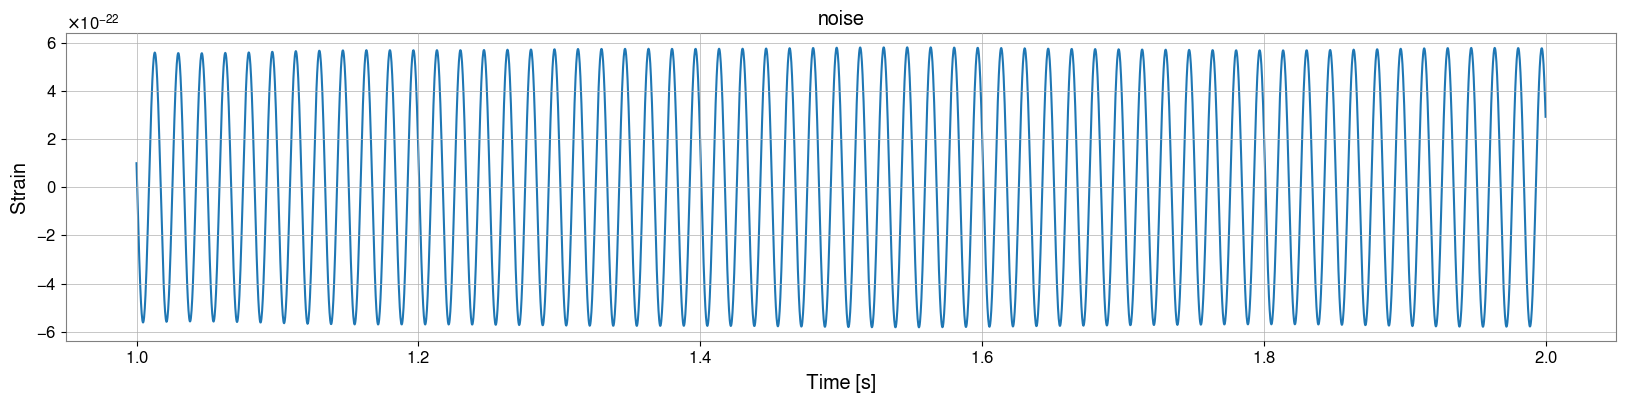

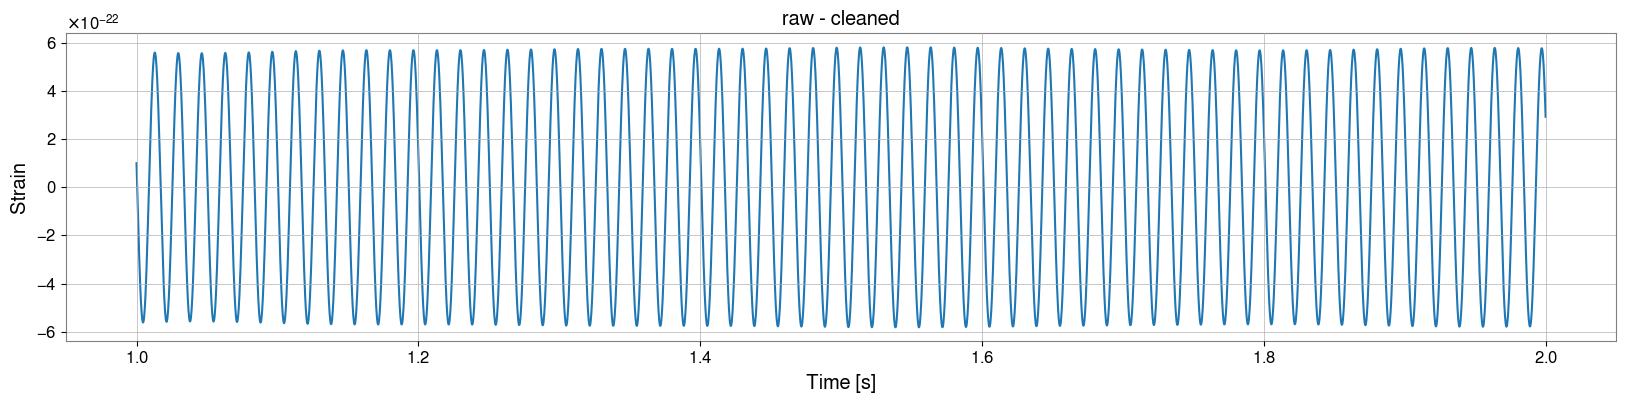

In [27]:
cleaned = raw - noise
plt.figure(figsize=[20, 4])
plt.title('Cleaned strain')
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.plot(times, cleaned.cpu().numpy())
plt.show()

plt.figure(figsize=[20, 4])
plt.title('noise')
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.plot(times, noise.cpu().numpy())
plt.show()

plt.figure(figsize=[20, 4])
plt.title('raw - cleaned')
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.plot(times, (raw - cleaned).cpu().numpy())
plt.show()

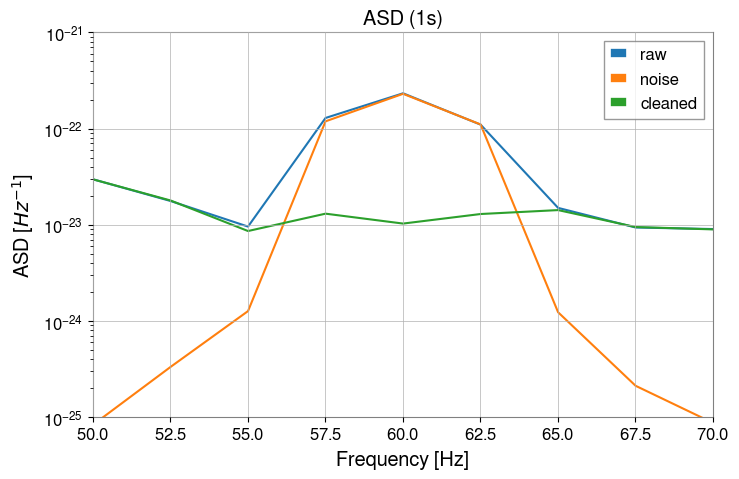

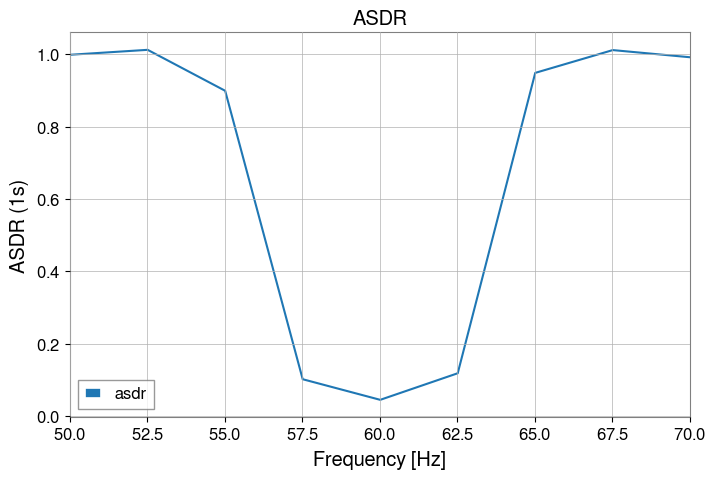

In [28]:
from gwpy.timeseries import TimeSeries
raw_ts = TimeSeries(
    raw.cpu().numpy(),
    t0=1,
    sample_rate=sample_rate,
)
noise_ts = TimeSeries(
    noise.cpu().numpy(),
    t0=1,
    sample_rate=sample_rate,
)
cleaned_ts = TimeSeries(
    cleaned.cpu().numpy(),
    t0=1,
    sample_rate=sample_rate,
)

fftlength=0.4
overlap=fftlength/2
raw_asd = raw_ts.asd(
    fftlength=fftlength,
    overlap=overlap,
)
noise_asd = noise_ts.asd(
    fftlength=fftlength,
    overlap=overlap,
)
cleaned_asd = cleaned_ts.asd(
    fftlength=fftlength,
    overlap=overlap,
)
asdr = cleaned_asd/raw_asd

flow, fhigh = 50, 70
plt.figure(figsize=[8,5])
plt.title('ASD (1s)')
plt.plot(raw_asd.frequencies, raw_asd, label='raw')
plt.plot(noise_asd.frequencies, noise_asd, label='noise')
plt.plot(cleaned_asd.frequencies, cleaned_asd, label='cleaned')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'ASD [$Hz^{-1}$]')
plt.xlim([flow, fhigh])
plt.ylim([1e-25, 1e-21])
# plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure(figsize=[8,5])
plt.title('ASDR')
plt.plot(asdr.frequencies, asdr, label='asdr')
plt.xlim([flow, fhigh])
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASDR (1s)')
# plt.xscale('log')
# plt.ylim([1e-25, 1e-21])
# plt.yscale('log')
plt.legend()
plt.show()